<a href="https://colab.research.google.com/github/linhlinhle997/neural-translation-en-vi/blob/develop/nt_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets

In [ ]:
import os
from datasets import load_dataset
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from tokenizers import Tokenizer, pre_tokenizers, trainers, models
from transformers import (
    PreTrainedTokenizerFast,
    PreTrainedModel,
    PretrainedConfig,
    Trainer,
    TrainingArguments
)

## Data Preprocessing

In [ ]:
ds = load_dataset("thainq107/iwslt2015-en-vi")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/522 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/133317 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1268 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1268 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['en', 'vi'],
        num_rows: 133317
    })
    validation: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
    test: Dataset({
        features: ['en', 'vi'],
        num_rows: 1268
    })
})

Word-Based

In [ ]:
tokenizer_en = Tokenizer(models.WordLevel(unk_token="<unk>"))
tokenizer_vi = Tokenizer(models.WordLevel(unk_token="<unk>"))

tokenizer_en.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer_vi.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.WordLevelTrainer(
    vocab_size=15000,
    min_frequency=2,
    special_tokens=["<pad>", "<unk>", "<bos>", "<eos>"]
)

Trains Tokenizer

In [ ]:
tokenizer_en.train_from_iterator(ds["train"]["en"], trainer)
tokenizer_vi.train_from_iterator(ds["train"]["vi"], trainer)

Tokenizer

In [ ]:
tokenizer_en.save("tokenizer_en.json")
tokenizer_vi.save("tokenizer_vi.json")

## Encoding

In [ ]:
MAX_LEN = 75

tokenizer_en = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_en.json",
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<bos>",
    eos_token="<eos>"
)

tokenizer_vi = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_vi.json",
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<bos>",
    eos_token="<eos>"
)

In [ ]:
def preprocess_func(examples):
    src_texts = examples["en"]
    tgt_texts = ["<bos>" + sent + "<eos>" for sent in examples["vi"]]

    src_encodings = tokenizer_en(
        src_texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

    tgt_encodings = tokenizer_vi(
        tgt_texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

    return {
        "input_ids": src_encodings["input_ids"],
        "labels": tgt_encodings["input_ids"]
    }


preprocessed_ds = ds.map(preprocess_func, batched=True)

Map:   0%|          | 0/133317 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

Map:   0%|          | 0/1268 [00:00<?, ? examples/s]

## GRU Model

In [ ]:
class Seq2SeqConfig(PretrainedConfig):
    def __init__(
        self,
        vocab_size_src=10000,
        vocab_size_tgt=10000,
        embedding_dim=128,
        hidden_size=128,
        dropout=0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.dropout = dropout

In [ ]:
class EncoderGRU(nn.Module):
    def __init__(
        self,
        input_size,
        embedding_dim,
        hidden_size,
        dropout_p=0.1
    ):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input)) # (batch_size, seq_len, embedding_dim)
        output, hidden = self.gru(embedded) # output: (batch_size, seq_len, hidden_size), hidden: (1, batch_size, hidden_size)
        return output, hidden


class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, embedding_dim, output_size):
        super(DecoderGRU, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.embedding(input) # (batch_size, 1, embedding_dim)
        output, hidden = self.gru(output, hidden) # output: (batch_size, 1, hidden_size)
        output = self.out(output) # (batch_size, 1, output_size)
        return output, hidden

In [ ]:
class Seq2SeqGRUModel(PreTrainedModel):
    config_class = Seq2SeqConfig

    def __init__(self, config, tokenizer_en):
        super().__init__(config)
        self.encoder = EncoderGRU(
            config.vocab_size_src,
            config.embedding_dim,
            config.hidden_size,
            config.dropout
        )
        self.decoder = DecoderGRU(
            config.hidden_size,
            config.embedding_dim,
            config.vocab_size_tgt
        )
        self.BOS_IDX = tokenizer_en.bos_token_id
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=0) # Ignore PAD token

    def forward(self, input_ids, labels):
        batch_size, seq_len = labels.shape

        decoder_input = torch.full((batch_size, 1), self.BOS_IDX, dtype=torch.long).to(input_ids.device)
        encoder_output, decoder_hidden = self.encoder(input_ids)

        decoder_outputs = []
        for i in range(seq_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)
            decoder_input = labels[:, i].unsqueeze(1) # Teacher forcing

        logits = torch.cat(decoder_outputs, dim=1) # (batch_size, seq_len, vocab_size_tgt)
        loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return {"loss": loss, "logits": logits}

In [ ]:
config = Seq2SeqConfig(
    vocab_size_src=len(tokenizer_en),
    vocab_size_tgt=len(tokenizer_vi)
)

model = Seq2SeqGRUModel(config, tokenizer_en)

Test model

In [ ]:
input_ids = torch.tensor([preprocessed_ds["train"][0]["input_ids"]])
labels = torch.tensor([preprocessed_ds["train"][0]["labels"]])

pred = model(input_ids, labels)

## Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./en-vi-mt",
    logging_dir="logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",  # Log by steps instead of epoch
    logging_steps=10, # Log loss every 10 steps
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=25,
    learning_rate=2e-5,
    save_total_limit=1,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_ds["train"],
    eval_dataset=preprocessed_ds["validation"]
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,5.931200,5.956331
2,5.607200,5.665993
3,5.393400,5.455819
4,5.302300,5.291824
5,5.138800,5.162796
6,4.993800,5.060518
7,4.921700,4.978884
8,4.878300,4.913017
9,4.788800,4.857277
10,4.697700,4.810308


TrainOutput(global_step=104175, training_loss=4.85976844641125, metrics={'train_runtime': 8550.9574, 'train_samples_per_second': 389.772, 'train_steps_per_second': 12.183, 'total_flos': 2944709228925000.0, 'train_loss': 4.85976844641125, 'epoch': 25.0})

Display charts

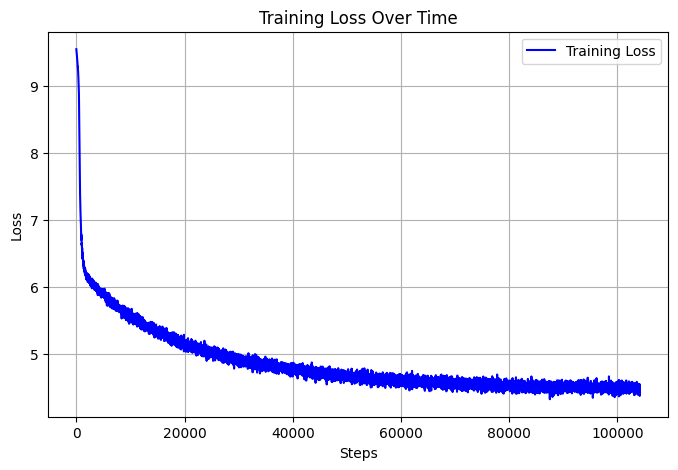

In [ ]:
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = [log["step"] for log in trainer.state.log_history if "loss" in log]

plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid()
plt.show()

## Inference

In [ ]:
def translate(model, src_sentence, tokenizer_en, tokenizer_vi, max_len=75, device="cpu"):
    model.eval()

    inputs = tokenizer_en(
        src_sentence,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    input_ids = inputs["input_ids"].to(device)

    # Get encoder output and hidden state
    _, decoder_hidden = model.encoder(input_ids)

    # Start with BOS token for decoder
    decoder_input = torch.tensor([[tokenizer_vi.bos_token_id]]).to(device)

    output_ids = []

    # Decode one token at a time
    for i in range(max_len):
        # Get decoder output
        decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)

        # Get most probable word
        decoder_output = decoder_output.squeeze(1)
        _, topi = decoder_output.topk(1)
        predicted_token_id = topi.item()

        output_ids.append(predicted_token_id)

        # Stop if EOS token
        if predicted_token_id == tokenizer_vi.eos_token_id:
            break

        # Use predicted token as next input
        decoder_input = topi.reshape(1, 1)

    # Convert output tokens to a sentence
    output_text = tokenizer_vi.decode(output_ids, skip_special_tokens=True)

    return output_text

In [ ]:
src_sentence = "Who are you?"

output_text = translate(model, src_sentence, tokenizer_en, tokenizer_vi, device=device)

print(f"Source: {src_sentence}")
print(f"Translation: {output_text}")

Source: Who are you?
Translation: Đây là một người khác .


In [ ]:
|